# **HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

## Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

### Load dataset:
In this HW, we use the IMD dataset that can be easily downloaded using Keras. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [2]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Let's also get the word indexs (word to word-id)

*   List item
*   List item



In [3]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [4]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [5]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [6]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [7]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation="sigmoid"))

Since the model performs a binary classification task, we use cross-entropy as loss.

In [9]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1376      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


### Train the model:
Now we have to train the model

In [11]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 28s 138ms/step - loss: 0.6907 - accuracy: 0.5202 - val_loss: 0.6358 - val_accuracy: 0.6444
Epoch 2/10
196/196 [==============================] - 25s 128ms/step - loss: 0.5065 - accuracy: 0.7690 - val_loss: 0.4016 - val_accuracy: 0.8292
Epoch 3/10
196/196 [==============================] - 25s 127ms/step - loss: 0.3086 - accuracy: 0.8760 - val_loss: 0.3796 - val_accuracy: 0.8417
Epoch 4/10
196/196 [==============================] - 25s 128ms/step - loss: 0.2288 - accuracy: 0.9149 - val_loss: 0.4271 - val_accuracy: 0.8370
Epoch 5/10
196/196 [==============================] - 25s 127ms/step - loss: 0.1807 - accuracy: 0.9368 - val_loss: 0.3971 - val_accuracy: 0.8473
Epoch 6/10
196/196 [==============================] - 25s 127ms/step - loss: 0.1394 - accuracy: 0.9539 - val_loss: 0.4431 - val_accuracy: 0.8450
Epoch 7/10
196/196 [==============================] - 25s 126ms/step - loss: 0.0948 - accuracy: 0.9711 - val_loss: 0.4574 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 8s - loss: 0.5465 - accuracy: 0.8429
accuracy: 84.29%


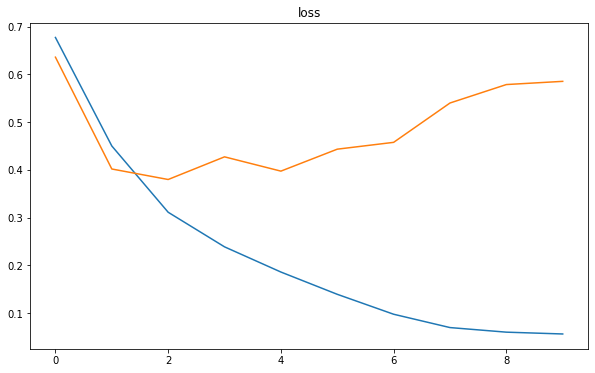

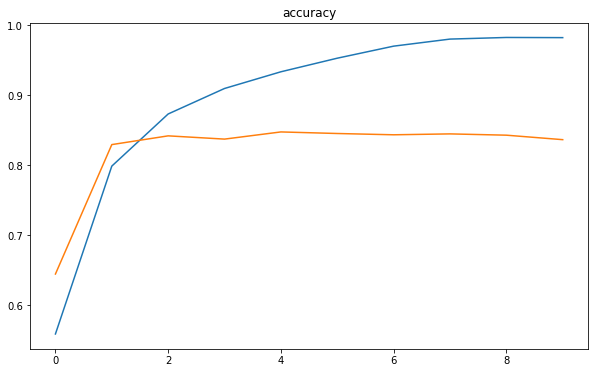

In [12]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Exercise 4.1: LSTM and GRU
**To complete**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**To complete**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

*insert cells (code and text) with results and discussion below*

### LSTM model


In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(14))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 14)                1400      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 37s 224ms/step - loss: 0.6567 - accuracy: 0.6083 - val_loss: 0.4343 - val_accuracy: 0.8374
Epoch 2/10
157/157 [==============================] - 37s 235ms/step - loss: 0.3595 - accuracy: 0.8695 - val_loss: 0.3138 - val_accuracy: 0.8684
Epoch 3/10
157/157 [==============================] - 41s 262ms/step - loss: 0.2533 - accuracy: 0.9123 - val_loss: 0.2984 - val_accuracy: 0.8822
Epoch 4/10
157/157 [==============================] - 39s 247ms/step - loss: 0.1911 - accuracy: 0.9361 - val_loss: 0.2947 - val_accuracy: 0.8848
Epoch 5/10
157/157 [==============================] - 39s 249ms/step - loss: 0.1462 - accuracy: 0.9543 - val_loss: 0.3076 - val_accuracy: 0.8848
Epoch 6/10
157/157 [==============================] - 38s 244ms/step - loss: 0.1092 - accuracy: 0.9692 - val_loss: 0.3439 - val_accuracy: 0.8802
Epoch 7/10
157/157 [==============================] - 39s 246ms/step - loss: 0.1019 - accuracy: 0.9711 - val_loss: 0.3539 - val_ac

391/391 - 9s - loss: 0.5069 - accuracy: 0.8511
accuracy: 85.11%


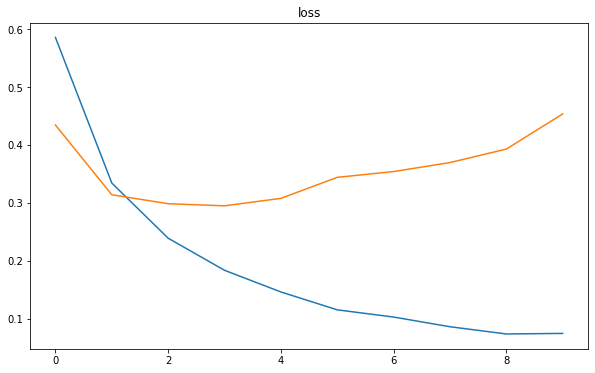

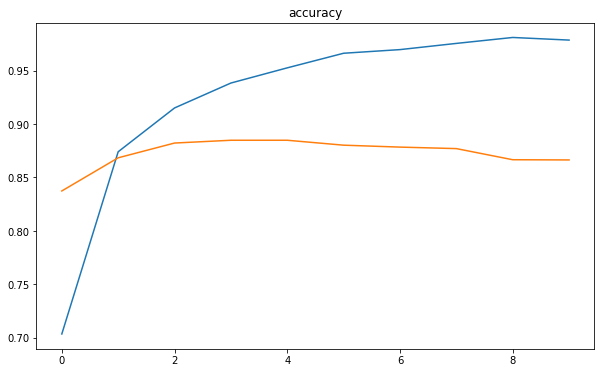

In [16]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

### GRU model

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.GRU(16))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
gru (GRU)                    (None, 16)                1344      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 36s 218ms/step - loss: 0.6739 - accuracy: 0.5750 - val_loss: 0.4189 - val_accuracy: 0.8160
Epoch 2/10
157/157 [==============================] - 37s 238ms/step - loss: 0.3393 - accuracy: 0.8611 - val_loss: 0.3333 - val_accuracy: 0.8624
Epoch 3/10
157/157 [==============================] - 38s 241ms/step - loss: 0.2318 - accuracy: 0.9147 - val_loss: 0.3165 - val_accuracy: 0.8730
Epoch 4/10
157/157 [==============================] - 38s 240ms/step - loss: 0.1889 - accuracy: 0.9347 - val_loss: 0.3329 - val_accuracy: 0.8724
Epoch 5/10
157/157 [==============================] - 38s 242ms/step - loss: 0.1596 - accuracy: 0.9442 - val_loss: 0.3464 - val_accuracy: 0.8696
Epoch 6/10
157/157 [==============================] - 38s 241ms/step - loss: 0.1368 - accuracy: 0.9575 - val_loss: 0.3802 - val_accuracy: 0.8708
Epoch 7/10
157/157 [==============================] - 40s 254ms/step - loss: 0.1184 - accuracy: 0.9631 - val_loss: 0.4037 - val_ac

391/391 - 13s - loss: 0.4886 - accuracy: 0.8517
accuracy: 85.17%


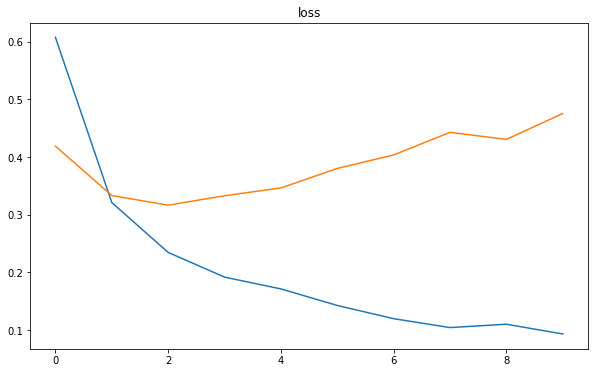

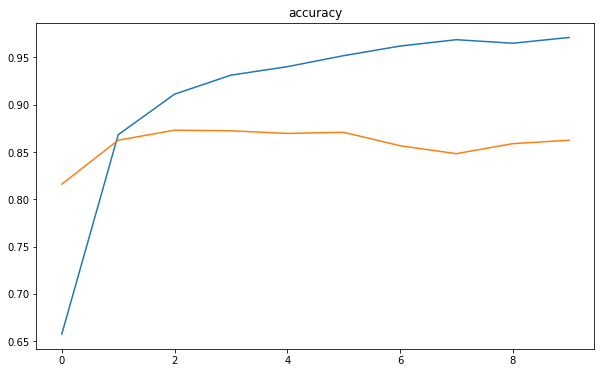

In [20]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

The best results are recoreded in the previous cells after changing several hyper-parameters like LSTM layer and GRU layer, batch size of all 3 and the no. of epochs. The number of units for the modified layer in the LSTM and GRU network were obtained to be:
* 14 Units in the LSTM model, giving a total of 101415 trainable parameters
* 16 Units in the GRU model, with 101361 trainable parameters
which was close to the 101409 parameters the simple RNN trains.

We conclude from the analysis that the simple RNN model and the LSTM and GRU have similar accuracy and tendency to overfit. If we take a closer look, we can see that the LSTM model shows us a greater dispersion than the GRU. Because of these gates, although it makes LSTMs more sophisticated, it makes them more complex and timely. 
The GRU was more efficient as the training took less time. Although it showed a lower accuracy than the LSTM network, it improved the simple RNN.
Changning the batch size and epoch didn't give better results.

## Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [21]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 88s 538ms/step - loss: 0.6584 - accuracy: 0.5915 - val_loss: 0.4153 - val_accuracy: 0.8338
Epoch 2/10
157/157 [==============================] - 83s 531ms/step - loss: 0.3489 - accuracy: 0.8666 - val_loss: 0.3074 - val_accuracy: 0.8702
Epoch 3/10
157/157 [==============================] - 82s 523ms/step - loss: 0.2391 - ac

391/391 - 18s - loss: 0.5392 - accuracy: 0.8533
accuracy: 85.33%


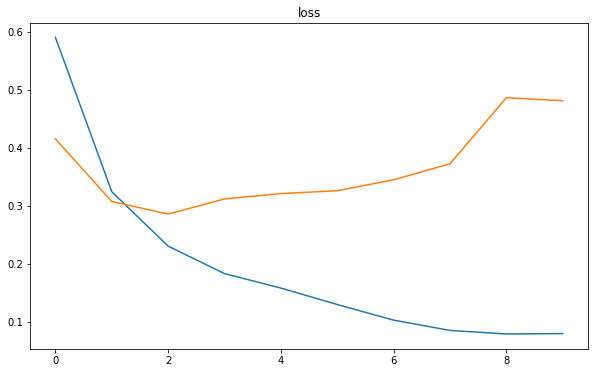

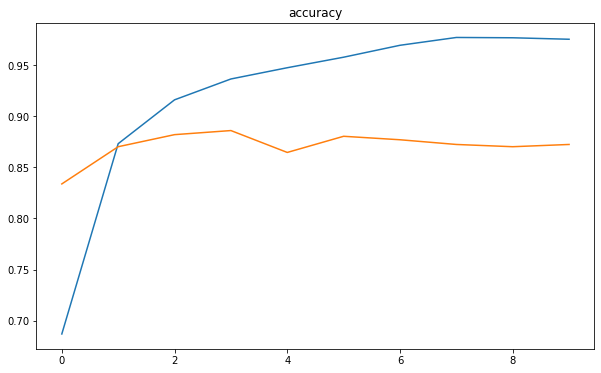

In [22]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

## Exercise 4.2: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**To complete**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue. Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion below*

Adding a dropout layer after 
* the input layer, 
* the bidirectional layer, 
* both of them

It was evident that the best choice was to add a dropout layer after both of them as the model learns better. Adding a dropout after input or before output doesn't yield better results, but we can say that adding a dropout before our output layer gives us improved accuracy. Using the dropout rates (0.1, 0.2, 0.4, 0.6, 0.8) we derived the following results.

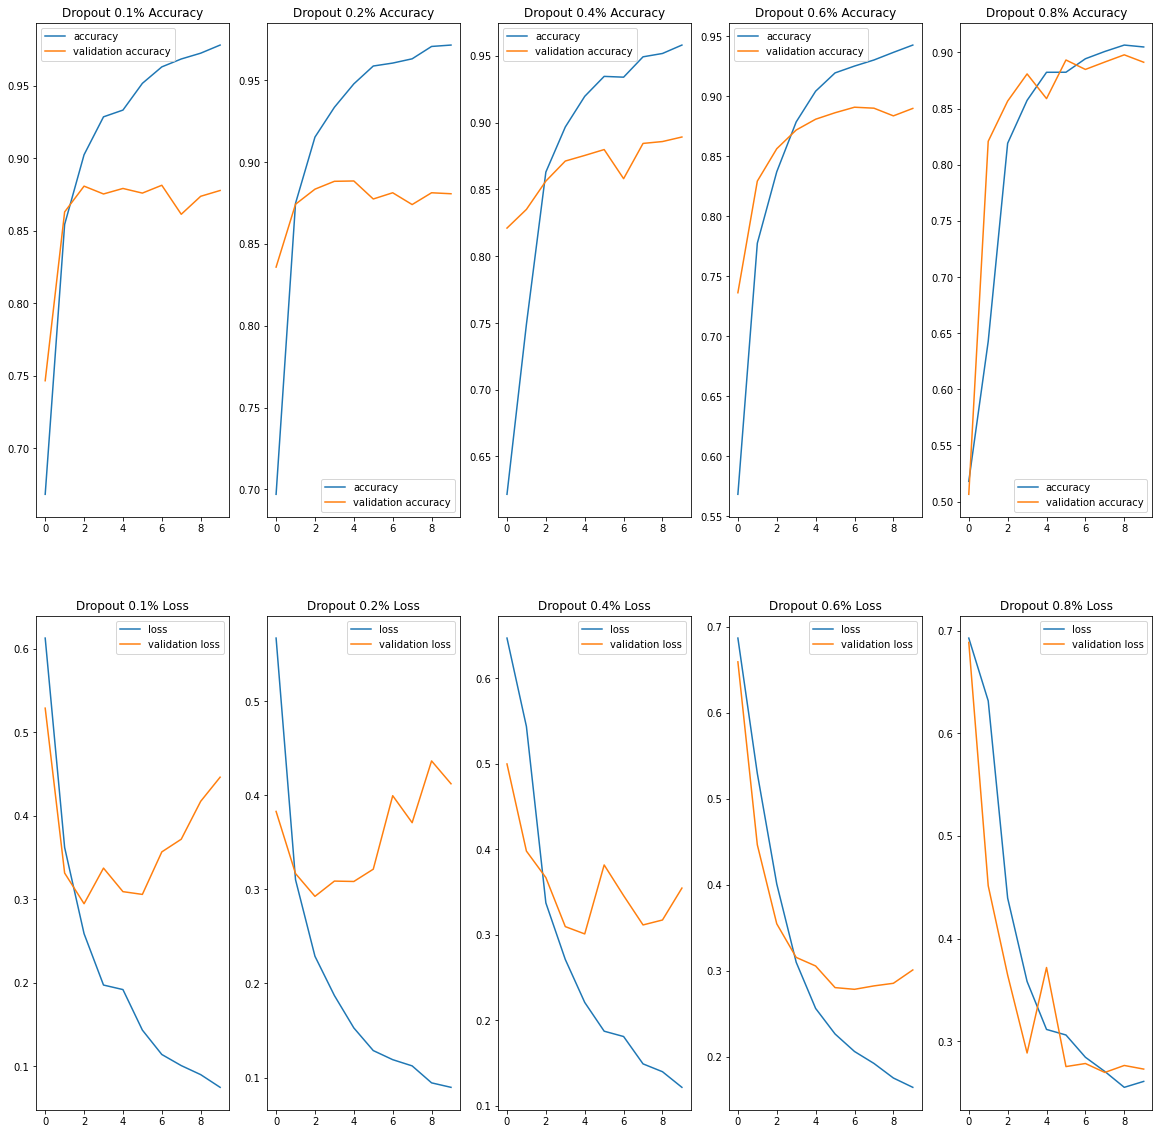

In [24]:
fig, axs = plt.subplots(2, 5, figsize=(20,20))

i = 0
for drop in [0.1, 0.2, 0.4, 0.6, 0.8]:
    model_bidirectional = keras.models.Sequential()
    model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
    model_bidirectional.add(keras.layers.Dropout(drop))
    model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
    model_bidirectional.add(keras.layers.Dropout(drop))
    model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

    model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model_bidirectional.fit(X_train_trim, y_train,
                      epochs=10, batch_size=128, validation_split=0.2, verbose=0)
  
    axs[0, i].plot(history.epoch,history.history['accuracy'], label="accuracy")
    axs[0, i].plot(history.epoch,history.history['val_accuracy'], label="validation accuracy")
    axs[0, i].legend()
    axs[0, i].set_title(f"Dropout {drop}% Accuracy")
    axs[1, i].plot(history.epoch,history.history['loss'], label="loss")
    axs[1, i].plot(history.epoch,history.history['val_loss'], label="validation loss")
    axs[1, i].legend()
    axs[1, i].set_title(f"Dropout {drop}% Loss")
    i+=1

By trying out several probabilities of the dropout, we can clearly see that 0.8 reduces the overfitting the most, but it still does not solve it. With changing hyper-parameters, we can mitigate the problem of overfitting. 

Even though too large of a batch size leads to poor generalization, we can increase it to 256 / 512 / 1024 / 2048, and to help our model perform better we can increase the number of epochs to 30, 40, and 50. Additionally, by checking for different optimizers in the Keras documentation, we conclude that Adamax could be used, since it's an optimizer that performs better than Adam in models with embeddings. 

After trying several models with epochs increased to 40 and 50, and tweaking the other parameters left, there weren't any better results since learning kind of stopped and the model didn't improve. By increasing the batch size to 2048 (with 30, 40, 50 epochs), the data behaved strangely and there were a lot of spikes in the validation loss curves; so this was ruled out even when the accuracy increased. Similarly, by decreasing the batch to a 512 gave a lot of volatility in the loss curve.  I decide to leave the batch size to 1024 and hence obtain 88.01% accuracy which is better from in the baseline model using only the Bidirectional RNN without dropout:

In [25]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(0.8))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dropout(0.8))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer='Adamax', metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=30, batch_size=1024, validation_split=0.2)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 10)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                11008     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
20/20 [==============================] - 68s 3s/step - loss: 0.6933 - accuracy: 0.4971 - val_loss: 0.6

391/391 - 19s - loss: 0.3032 - accuracy: 0.8801
accuracy: 88.01%


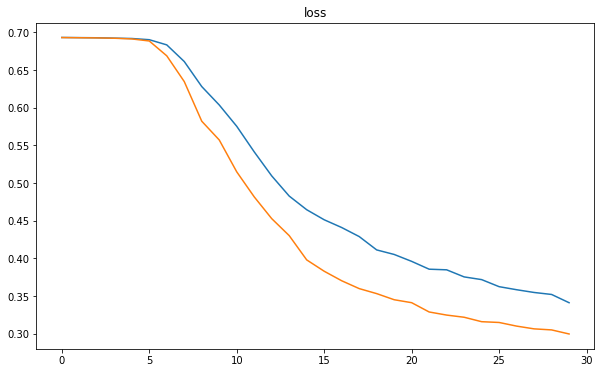

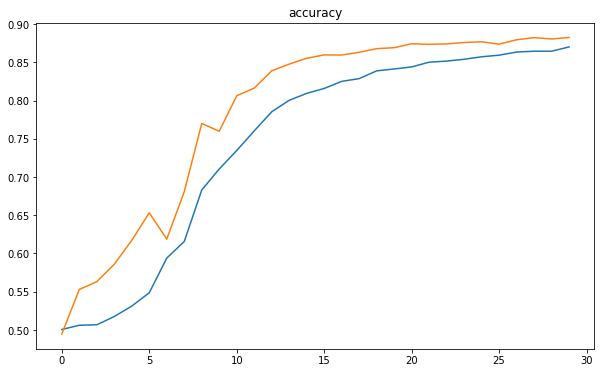

In [26]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))